Using simple 1d examples to test whether our spline implementation is indeed correct or not

But at first I wanna test the output of a single node. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained

import os
import json
from tqdm import tqdm

# dataset (2 moons)
from sklearn.datasets import make_moons


In [2]:
# single_activation = LinearSplineSlopeConstrained(mode='fc',
#                                             num_activations=1,
#                                             size=101,
#                                             range_=-10,
#                                             init="maxmin",
#                                             smin=0.0001,
#                                             smax=1/0.0001,
#                                             slope_constrained=True)

In [3]:
def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.

    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)

    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)

    return tv2[0] 

In [4]:
# TV2(single_activation, single_activation.coefficients_vect.device)

So TV2 seems to be working now!

In [16]:
# Function to generate data from a 1D Gaussian distribution
def generate_gaussian_data(mean, 
            std_dev, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 1D Gaussian distribution.

    Parameters:
    - mean: Mean of the Gaussian distribution
    - std_dev: Standard deviation of the Gaussian distribution
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate data
    data = np.random.normal(loc=mean, scale=std_dev, size=total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


mean = 1
std_dev = 2
total_samples = 10#50000

train_data, val_data, test_data = generate_gaussian_data(mean, std_dev, total_samples)
# Reshape data before returning
train_data = train_data.reshape(-1, 1)
val_data = val_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Convert to DataLoaders
batch_size = 3#32
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")


Training set size: 7
Validation set size: 1
Test set size: 2


In [6]:
# Now i need to train this model using NLL loss
def nll_loss(z, det_jacobian):
    '''
    z :  tensor z in latent space
    det_jacobian : det(J_{f}(xi)) for each xi (we will take abs in this fn later)
    '''
    loss_1 = 0.5 * torch.sum(z**2)
    loss_2 = torch.sum(torch.log(torch.abs(det_jacobian) + 1e-10))
    dataset_length = z.size(0)
    loss = (loss_1-loss_2)/ dataset_length
    return loss

Now let's solve this for the one dimensional problem:

In [7]:
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [8]:
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1
    , track_coefficients = False
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded = model(inputs)

            # Loss calculation
            ## Normal loss term
            train_loss = nll_loss(encoded, model.grad_x_temp)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)

            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss

            # Backward pass (gradient computation)
            total_loss.backward()

            # Update weights
            optimizer.step()
            total_train_loss += total_loss.item()

        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # i commented it because i also want to see how coefficients look before the training begins
        # if track_coefficients:
        #     # do I really need to change them to numpy?
        #     coeffs=model.coefficients_vect.detach().numpy()
        #     slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
        #     coeffs_evol.append(list(coeffs))
        #     slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded = model(val_inputs)

                    # Loss calculation for validation
                    val_loss = nll_loss(val_encoded, model.grad_x_temp)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f"Training Loss: {average_train_loss}, "
                    f"Validation Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses


In [9]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [10]:
def plot_code_distribution(model, test_loader, num_samples=1000):
    """
    Plot the code distribution obtained by applying the trained NF model to a test dataset
    and compare it to a standard normal distribution.

    Args:
    - model (NF): Trained NF model.
    - test_loader (DataLoader): DataLoader for the test dataset.
    - num_samples (int): Number of samples to visualize.

    Returns:
    None (displays the plot).
    """
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():
        # Concatenate multiple batches to obtain more samples
        test_samples = torch.cat([batch[0] for batch in test_loader])

        # Apply the model to the test samples
        code_samples = model(test_samples[:num_samples])

        # Convert PyTorch tensor to numpy array
        code_np = code_samples.numpy()

        # Generate samples from a standard normal distribution
        normal_samples = np.random.normal(loc=0, scale=1, size=num_samples)

        # Plot histograms of the code distribution and the standard normal distribution
        plt.figure(figsize=(10, 6))

        # Histogram for the code samples
        plt.hist(code_np, bins=25, alpha=0.7, color='blue', density=True, label="Code Distribution")

        # Histogram for the standard normal samples
        plt.hist(normal_samples, bins=25, alpha=0.7, color='orange', density=True, label="Standard Normal Distribution")

        # Add labels, legend, and title
        plt.xlabel("Value")
        plt.ylabel("Density")
        plt.title("Comparison of Code Distribution and Standard Normal Distribution")
        plt.legend()
        plt.show()


In [11]:
def plot_multiple_histogram(list_of_inputs, labels_list):
    # add a code line here: if the inputs are not numpy, convert them to numpy
    plt.figure(figsize=(10, 6))

    for i in range(0,len(list_of_inputs)):
        # Histogram for the code samples
        plt.hist(list_of_inputs[i], bins=50, alpha=0.7, 
                density=True, label=labels_list[i])
        plt.legend()

In [12]:
def plot_coefficients_evolution(num_coeffs,coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs= List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    
    '''
    plt.figure(figsize=(10, 6))

    for i in range(0,num_coeffs):
        plt.plot(coeffs[:,i],"-o",label=f"coeff[{i}]")
        plt.plot(slope_constr_coeffs[:,i],":o",label=f"slope constr coeff[{i}]")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    if log_scale:
        plt.yscale("log")
    plt.xlabel("training epochs")
    plt.ylabel("coefficient values")
    plt.grid(1)
    plt.title("Evolution of coefficients with training of a spline")
    plt.tight_layout()


Testing code:
Setting coefficients such that the output is same as the input

Sanity check 1

In [13]:
out_as_in_model = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=5,# number of knots is size -2
                        range_=10,
                        init="identity",#"maxmin",# what if I try relu activation function?
                        smin=0.00001,
                        smax=1/0.00001,
                        slope_constrained=True
) # slopes of splines is 1, obviously

initial nodal_val_locs: tensor([[-4.2030, -1.4953, -1.2940,  3.6284,  8.5780]])
initial fn values: Parameter containing:
tensor([-4.2030, -1.4953, -1.2940,  3.6284,  8.5780], requires_grad=True)


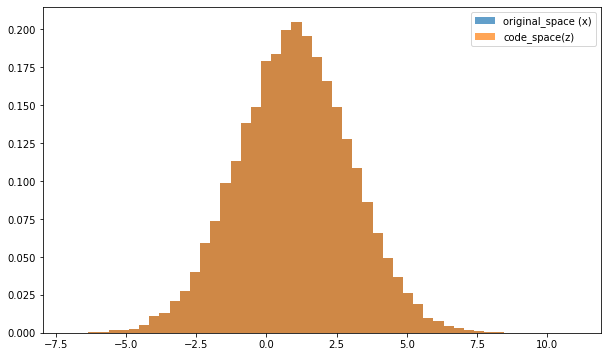

In [14]:
input_tensor = torch.tensor(train_data)
output_tensor=out_as_in_model(input_tensor)
plot_multiple_histogram([input_tensor.numpy(), output_tensor.detach().numpy()],
                        labels_list=["original_space (x)","code_space(z)"])

Distributions are overlapping. That is a good sign. So code is correct

Simple 1-D case:

from what i suspect, I feel like i only considered single grad_x

In [ ]:
# let's instantiate our model, once again
single_activation = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=5,# number of knots is size -2
                        range_=10,
                        grid_values=torch.tensor([-6.3, 
                                -4,  2.7,  4.5,  6.5]),#torch.tensor([-6.3529, 
                                # -4.4832,  2.7023,  4.9222,  6.8397]),
                        init="relu",#"maxmin",# what if I try relu activation function?
                        smin=0.001,# 0.00001 ->0.75,0.001
                        smax=1/0.001,#1/0.00001 ->1.5,1/0.001
                        slope_constrained=True)

### let's run the trainer and see what kind of result it gives
train_loss, val_loss, coeffs_unconstrained_evol, coeffs_const_evol = train_and_evaluate(
    model = single_activation,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs=10, 
    scheduler_type="ReduceLROnPlateau",
    lr=0.001,
    print_after=1,
    track_coefficients=True
) # let's see what else can we do 
# is just the neural spline powerful enough to learn the underlying distribution


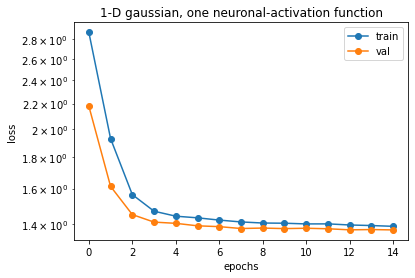

In [ ]:
plot_loss_curves(train_loss=train_loss, val_loss=val_loss, 
                title="1-D gaussian, one neuronal-activation function",
                log_scale=1)

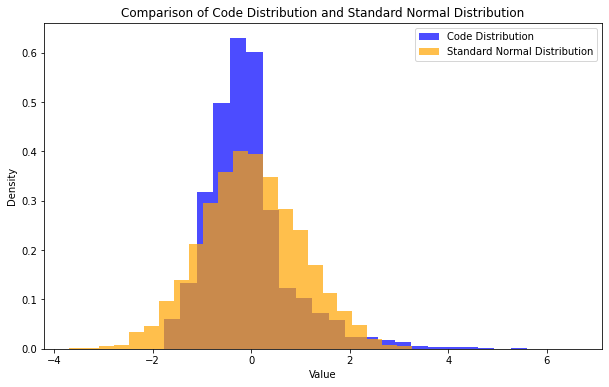

In [ ]:
plot_code_distribution(model=single_activation, 
                    test_loader=test_loader,
                    num_samples=len(test_data))
# so what i observed is that there is a strong influence of range and size in the training, like 
# really a lot. so maybe the best thing would be to use wandb and find the appropriate set of
# hyperparameters!

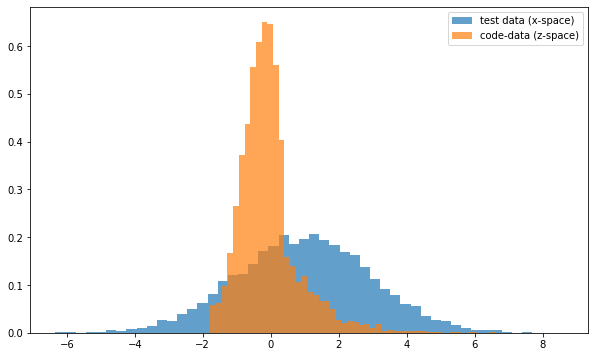

In [ ]:
test_op_without_tv2 =  single_activation(torch.tensor(test_data))
plot_multiple_histogram([test_data, test_op_without_tv2.detach().numpy()], 
                        labels_list=["test data (x-space)", "code-data (z-space)"])

Let's check how coefficients evolve with training

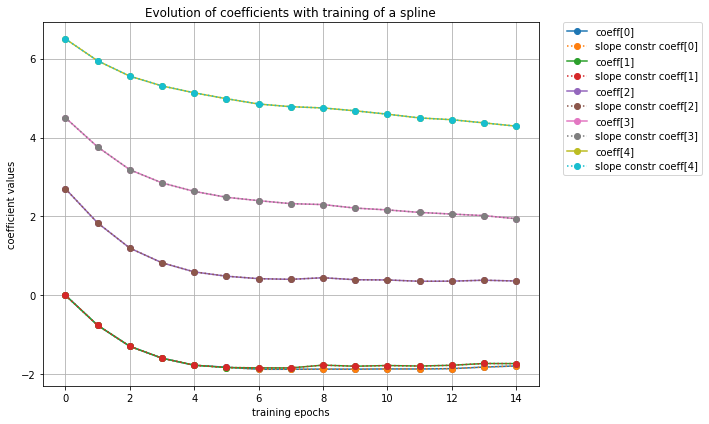

In [ ]:
plot_coefficients_evolution(5,
                        np.array(coeffs_unconstrained_evol), 
                        np.array(coeffs_const_evol), log_scale=0)

next we check how things change once we add TV-2 regularisation

In [28]:
# let's check the other case with TV2 regularisation
# let's instantiate our model, once again
single_activation2 = LinearSplineSlopeConstrained(
                        mode='fc',
                        num_activations=1,
                        size=5,# number of knots is size -2
                        range_=10,
                        grid_values=torch.tensor([-6.3529, 
                                -4.4832,  2.7023,  4.9222,  6.8397]),
                        init="relu",
                        smin=0.00001,
                        smax=1/0.00001,
                        slope_constrained=True)

### let's run the trainer and see what kind of result it gives
train_loss2, val_loss2, coeffs_evol_2, const_coeffs_evol_2 = train_and_evaluate(
    model = single_activation2,
    train_loader=train_loader,
    val_loader=val_loader, 
    num_epochs= 2, 
    lr=0.0002,
    scheduler_type='ReduceLROnPlateau',
    print_after=1,
    tv2_regulation=1 ,
    track_coefficients=1
) # let's see what else can we do 
# is just the neural spline powerful enough to learn the underlying distribution

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

initial nodal_val_locs: tensor([[-6.3529, -4.4832,  2.7023,  4.9222,  6.8397]])
initial fn values: Parameter containing:
tensor([0.0000, 0.0000, 2.7023, 4.9222, 6.8397], requires_grad=True)


Training Progress:   5%|▌         | 1/20 [00:10<03:26, 10.86s/it]

Epoch 1/20, Training Loss: 3.5640323615379264, Validation Loss: 3.344154930114746, LR: 0.0002


Training Progress:  10%|█         | 2/20 [00:24<03:40, 12.24s/it]

Epoch 2/20, Training Loss: 3.196705527453797, Validation Loss: 2.998351714966145, LR: 0.0002


Training Progress:  15%|█▌        | 3/20 [00:36<03:30, 12.38s/it]

Epoch 3/20, Training Loss: 2.8738364898744404, Validation Loss: 2.6989895906854184, LR: 0.0002


Training Progress:  20%|██        | 4/20 [00:47<03:10, 11.93s/it]

Epoch 4/20, Training Loss: 2.5942126949482907, Validation Loss: 2.4343015675849102, LR: 0.0002


Training Progress:  25%|██▌       | 5/20 [01:00<03:05, 12.36s/it]

Epoch 5/20, Training Loss: 2.3509012706972783, Validation Loss: 2.214259062929356, LR: 0.0002


Training Progress:  30%|███       | 6/20 [01:13<02:55, 12.53s/it]

Epoch 6/20, Training Loss: 2.1470892430441473, Validation Loss: 2.0255328031296425, LR: 0.0002


Training Progress:  35%|███▌      | 7/20 [01:26<02:45, 12.72s/it]

Epoch 7/20, Training Loss: 1.9736121697879143, Validation Loss: 1.872867575604865, LR: 0.0002


Training Progress:  40%|████      | 8/20 [01:39<02:31, 12.66s/it]

Epoch 8/20, Training Loss: 1.837053385796451, Validation Loss: 1.7451665436967891, LR: 0.0002


Training Progress:  45%|████▌     | 9/20 [01:50<02:13, 12.14s/it]

Epoch 9/20, Training Loss: 1.7205705320159521, Validation Loss: 1.646403735749265, LR: 0.0002


Training Progress:  50%|█████     | 10/20 [02:01<01:56, 11.65s/it]

Epoch 10/20, Training Loss: 1.628863646517724, Validation Loss: 1.5651510806793862, LR: 0.0002


Training Progress:  55%|█████▌    | 11/20 [02:10<01:40, 11.12s/it]

Epoch 11/20, Training Loss: 1.5637246655807635, Validation Loss: 1.5107847142726818, LR: 0.0002


Training Progress:  60%|██████    | 12/20 [02:21<01:26, 10.83s/it]

Epoch 12/20, Training Loss: 1.5131810255198854, Validation Loss: 1.4643445116408327, LR: 0.0002


Training Progress:  65%|██████▌   | 13/20 [02:30<01:13, 10.54s/it]

Epoch 13/20, Training Loss: 1.4716724471156732, Validation Loss: 1.4320094808619073, LR: 0.0002


Training Progress:  70%|███████   | 14/20 [02:41<01:02, 10.48s/it]

Epoch 14/20, Training Loss: 1.4454141848701882, Validation Loss: 1.4094993089107757, LR: 0.0002


Training Progress:  75%|███████▌  | 15/20 [02:51<00:51, 10.38s/it]

Epoch 15/20, Training Loss: 1.4262037503871883, Validation Loss: 1.3940213147630083, LR: 0.0002


Training Progress:  80%|████████  | 16/20 [03:01<00:40, 10.24s/it]

Epoch 16/20, Training Loss: 1.4111654170034573, Validation Loss: 1.381535906487323, LR: 0.0002


Training Progress:  85%|████████▌ | 17/20 [03:13<00:31, 10.65s/it]

Epoch 17/20, Training Loss: 1.401639550651885, Validation Loss: 1.3726519310728031, LR: 0.0002


Training Progress:  90%|█████████ | 18/20 [03:22<00:20, 10.41s/it]

Epoch 18/20, Training Loss: 1.3938873139988135, Validation Loss: 1.366055659030346, LR: 0.0002


Training Progress:  95%|█████████▌| 19/20 [03:34<00:10, 10.85s/it]

Epoch 19/20, Training Loss: 1.387883606405973, Validation Loss: 1.3624017073753032, LR: 0.0002


Training Progress: 100%|██████████| 20/20 [03:45<00:00, 11.26s/it]

Epoch 20/20, Training Loss: 1.383927068610078, Validation Loss: 1.3594114153943164, LR: 0.0002
Training complete


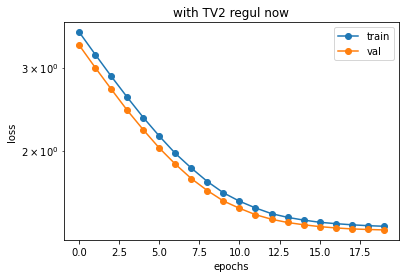

In [29]:
plot_loss_curves(train_loss2, val_loss2, title="with TV2 regul now", log_scale=True)

with TV2 regularisation now:


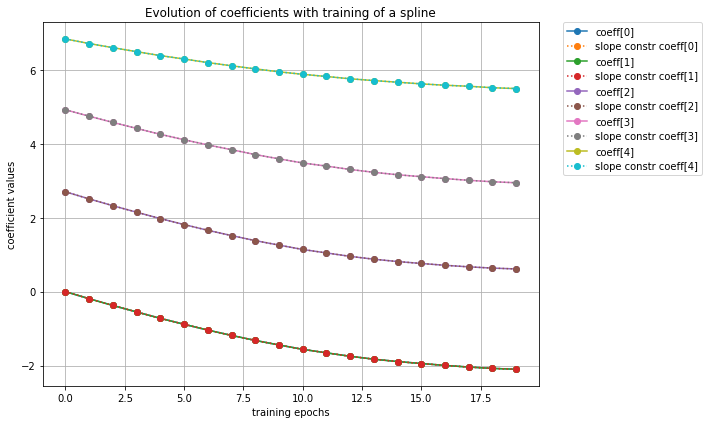

In [30]:
print("with TV2 regularisation now:") # currently I have considered 7 coefficients (num_coeffs=7)
plot_coefficients_evolution(num_coeffs=5,coeffs=np.array(coeffs_evol_2),
                            slope_constr_coeffs=np.array(const_coeffs_evol_2),
                            )

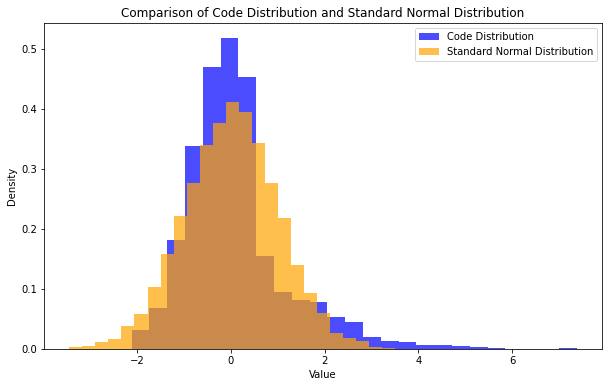

In [31]:
# this is with tv2 regularisation
plot_code_distribution(model=single_activation2, 
                    test_loader=test_loader,
                    num_samples=len(test_data))

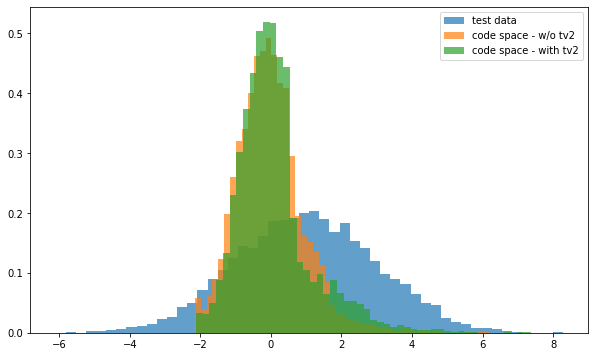

In [32]:
test_op_with_tv2 = single_activation2(torch.tensor(test_data))
plot_multiple_histogram(
    [test_data, test_op_without_tv2.detach().numpy(), test_op_with_tv2.detach().numpy()], 
    labels_list=["test data", "code space - w/o tv2", "code space - with tv2"])

In [33]:
print(single_activation.slopes_tensor(for_projected_coeffs=False))
print(single_activation.slopes_tensor(for_projected_coeffs=1))
print(single_activation.nodal_val_loc_tensor)
print(single_activation.coefficients_vect)
print(single_activation.slope_constrained_coefficients_vect)

tensor([[0.0059, 0.0059, 0.4110, 0.6043, 1.1943]], grad_fn=<CopySlices>)
tensor([[0.0059, 0.0059, 0.4110, 0.6043, 1.1943]], grad_fn=<ClampBackward1>)
tensor([[-6.3000, -4.0000,  2.7000,  4.5000,  6.5000]])
Parameter containing:
tensor([-2.1575, -2.1439,  0.6096,  1.6972,  4.0859], requires_grad=True)
tensor([-2.1575, -2.1439,  0.6096,  1.6972,  4.0859], grad_fn=<ViewBackward0>)


In [37]:
import matplotlib.pyplot as plt

def plot_with_annotations(x, y, title="Plot with (x, y) Annotations", xlabel="X-axis", ylabel="Y-axis"):
    """
    Plot x and y values with (x, y) annotations.

    Args:
    - x (array-like): Array of x-values.
    - y (array-like): Array of y-values.
    - title (str): Title of the plot.
    - xlabel (str): Label for the X-axis.
    - ylabel (str): Label for the Y-axis.

    Returns:
    - None
    """
    plt.plot(x, y, "-o")  # Plot the points with markers and lines

    # Annotate each point with its (x, y) coordinates
    for x_val, y_val in zip(x, y):
        plt.annotate(
            f"({x_val:.2f}, {y_val:.2f})",  # Format to 2 decimal places
            (x_val, y_val),  # The point to annotate
            textcoords="offset points",  # Offset the text slightly
            xytext=(5, 5),  # Offset (5, 5) pixels
            fontsize=8,  # Font size of the annotation
            color="red"  # Optional: text color
        )
        plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)  # Optional: Add a grid


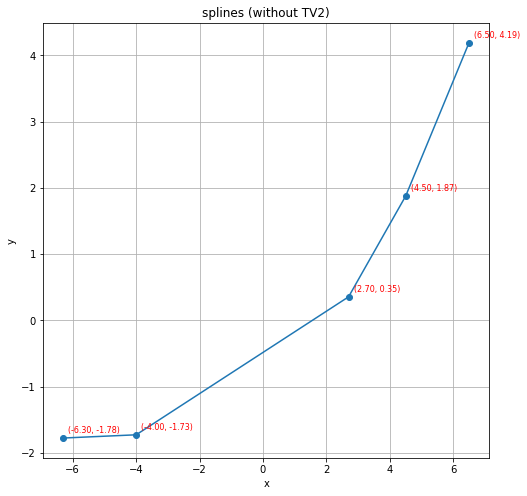

In [38]:
x1,y1= single_activation.nodal_val_loc_tensor.detach().numpy(),single_activation.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
plt.figure(figsize=(8,8))
plot_with_annotations(x1[0], y1,
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.show()

In [36]:
print(single_activation2.slopes_tensor(for_projected_coeffs=False))
print(single_activation2.slopes_tensor(for_projected_coeffs=1))
print(single_activation2.nodal_val_loc_tensor)
print(single_activation2.coefficients_vect)
print(single_activation2.slope_constrained_coefficients_vect)

tensor([[-1.9217e-04, -1.9217e-04,  3.7757e-01,  1.0479e+00,  1.3319e+00]],
       grad_fn=<CopySlices>)
tensor([[1.0000e-05, 1.0000e-05, 3.7757e-01, 1.0479e+00, 1.3319e+00]],
       grad_fn=<ClampBackward1>)
tensor([[-6.3529, -4.4832,  2.7023,  4.9222,  6.8397]])
Parameter containing:
tensor([-2.1206, -2.1209,  0.5921,  2.9184,  5.4723], requires_grad=True)
tensor([-2.1209, -2.1208,  0.5922,  2.9184,  5.4724], grad_fn=<ViewBackward0>)


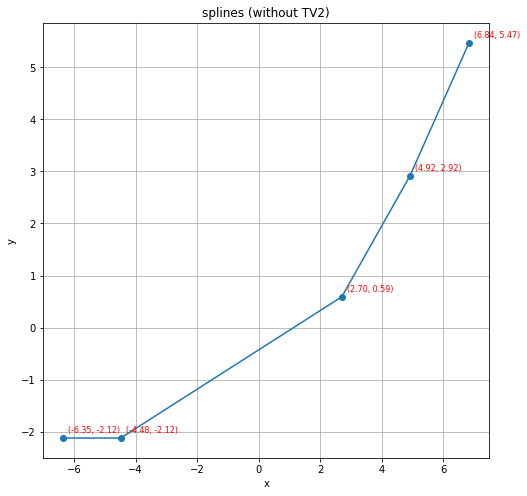

In [37]:
x2,y2= single_activation2.nodal_val_loc_tensor.detach().numpy(),single_activation2.slope_constrained_coefficients_vect.detach().numpy()
# Add labels, title, and grid
plt.figure(figsize=(8,8))
plot_with_annotations(x2[0], y2,
                    title="splines (without TV2)", xlabel="x", ylabel="y")
plt.show()

# TO DO:
1.  Need to go back to the paper and see what is the meaning of the TV2 regularisation.

2. (DONE) ~~Store the information of the slopes and coefficients (both unconstrained and constrained ones) for each epoch to see how they evolve as the training progresses!~~

3. (DONE)~~Learn a global scaling factor before applying the activation function. (in the new notebook)~~

4. Make problem a little bit more complex. Consider a 2D gaussian mixture and see how it behaves in that situation. 

Observation: strong dependence on slope, range, values of knots and number of knots considered